In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("/Users/galamboslajos/Desktop/Assignment_3/cs_bisnode_panel.csv")


In [3]:
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")
    .stack()
    .reset_index()
)
data = data.replace("toReplace", np.nan) 

In [4]:
data["status_alive"] = (data["sales"] > 0 & (False == data["sales"].isna())).astype(int)

# defaults in two years if there are sales in this year but no sales two years later
# Status_in_two_years: data.groupby('comp_id')['status_alive'].shift(-2)
data["default"] = (
    (data["status_alive"] == 1)
    & (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)



In [5]:
data = data.drop(
    columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)


In [6]:
data = data[(data['year'] >= 2010) & (data['year'] <= 2015)]
data


,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,status_alive,default
232060,2010,1.001034e+06,2010-01-01,2010-12-31,177.777771,2.096296e+03,1.962963e+04,0.000000,0.0,0.000000,...,5630.0,56.0,3.0,1.0,Central,1990-11-19,NaN,0.083333,1,1
232061,2010,1.001541e+06,2010-01-01,2010-12-31,0.000000,1.740741e+03,8.444445e+02,0.000000,0.0,0.000000,...,5610.0,56.0,3.0,3.0,Central,2008-02-24,NaN,NaN,0,0
232062,2010,1.002029e+06,2010-01-01,2010-12-31,22114.814453,2.307815e+05,2.025519e+05,0.000000,0.0,0.000000,...,2711.0,27.0,2.0,3.0,East,2006-07-03,NaN,0.479167,1,0
232063,2010,1.003200e+06,2010-01-01,2010-12-31,74.074074,9.222222e+02,5.388889e+03,0.000000,0.0,0.000000,...,5630.0,56.0,3.0,1.0,Central,2003-10-21,2014-08-09,NaN,1,0
232064,2010,1.004012e+06,2010-01-01,2010-12-31,0.000000,2.670370e+03,1.066667e+03,0.000000,0.0,0.000000,...,3314.0,33.0,2.0,3.0,West,1991-11-24,2013-06-19,0.083333,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510527,2015,4.640446e+11,2015-01-01,2015-12-31,83425.929688,6.532030e+06,2.253478e+06,0.000000,0.0,0.000000,...,3312.0,33.0,2.0,3.0,Central,2008-10-09,NaN,3.138889,1,0
510528,2015,4.640568e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
510529,2015,4.640793e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
510530,2015,4.641050e+11,2015-01-01,2015-12-31,1288.888916,6.638519e+04,1.375185e+04,18.518518,0.0,-18.518518,...,5610.0,56.0,3.0,3.0,West,1989-04-28,NaN,1.138889,1,0


In [7]:
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"]
) 
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ), 
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")["sales_mil_log"].shift(1)

In [8]:
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)
data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

In [9]:
data = data.query("status_alive == 1")
data = data.query("sales_mil<=10 & sales_mil>=0.001")

In [10]:
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [11]:
data["age2"] = data["age"] ** 2
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [12]:
data["profit_loss_year2"]=data["profit_loss_year"]**2

In [13]:
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.0    128260
1.0        65
Name: comp_id, dtype: int64

In [14]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [15]:
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count    1.283250e+05
mean     2.715624e+05
std      1.875274e+06
min      0.000000e+00
25%      7.577778e+03
50%      2.635556e+04
75%      1.037222e+05
max      3.190691e+08
Name: total_assets_bs, dtype: float64

In [16]:
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)

pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "profit_loss_year2",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [17]:
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [18]:
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

CEO

In [19]:
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 50).astype(int)

In [20]:
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [21]:
data['labor_avg_mod'].describe()

count    128355.000000
mean          0.666376
std           1.544744
min           0.000000
25%           0.151515
50%           0.340278
75%           0.666376
max          64.583336
Name: labor_avg_mod, dtype: float64

In [22]:
data = data.drop(['labor_avg'], axis=1)

In [23]:
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


In [24]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq
232060,2010,1.001034e+06,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.000000,0.000000,0.000000,...,1.000000,42.000000,0,0,0,1,0.083333,0,default,21.272685
232062,2010,1.002029e+06,2010-01-01,2010-12-31,22114.814453,230781.484375,202551.859375,0.000000,0.000000,0.000000,...,0.137182,35.000000,0,0,0,1,0.479167,0,no_default,0.028856
232063,2010,1.003200e+06,2010-01-01,2010-12-31,74.074074,922.222229,5388.888672,0.000000,0.000000,0.000000,...,1.000000,47.041769,0,0,1,1,0.666376,1,no_default,18.349431
232064,2010,1.004012e+06,2010-01-01,2010-12-31,0.000000,2670.370361,1066.666626,0.000000,0.000000,0.000000,...,0.010821,47.041769,0,0,1,1,0.083333,0,default,35.739107
232066,2010,1.007261e+06,2010-09-08,2010-12-31,0.000000,2459.259277,1348.148193,0.000000,0.000000,0.000000,...,0.204130,48.000000,0,0,0,1,0.666376,1,default,37.507800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510513,2015,4.637410e+11,2015-01-01,2015-12-31,285.185181,4262.962891,8366.666992,0.000000,0.000000,0.000000,...,0.593479,41.000000,0,0,0,1,0.116667,0,no_default,14.870301
510521,2015,4.638854e+11,2015-01-01,2015-12-31,7566.666504,85777.781250,62914.816406,0.000000,1207.407349,1207.407349,...,0.140851,37.000000,0,0,0,1,0.451389,0,no_default,0.379246
510524,2015,4.639820e+11,2015-01-01,2015-12-31,14433.333008,72855.554688,97992.593750,0.000000,0.000000,0.000000,...,0.211662,58.000000,0,0,0,0,0.625000,0,no_default,0.573412
510526,2015,4.640212e+11,2015-01-01,2015-12-31,6633.333496,12970.370117,3185.185303,0.000000,0.000000,0.000000,...,0.749427,65.000000,0,0,0,0,0.180556,0,no_default,10.138598


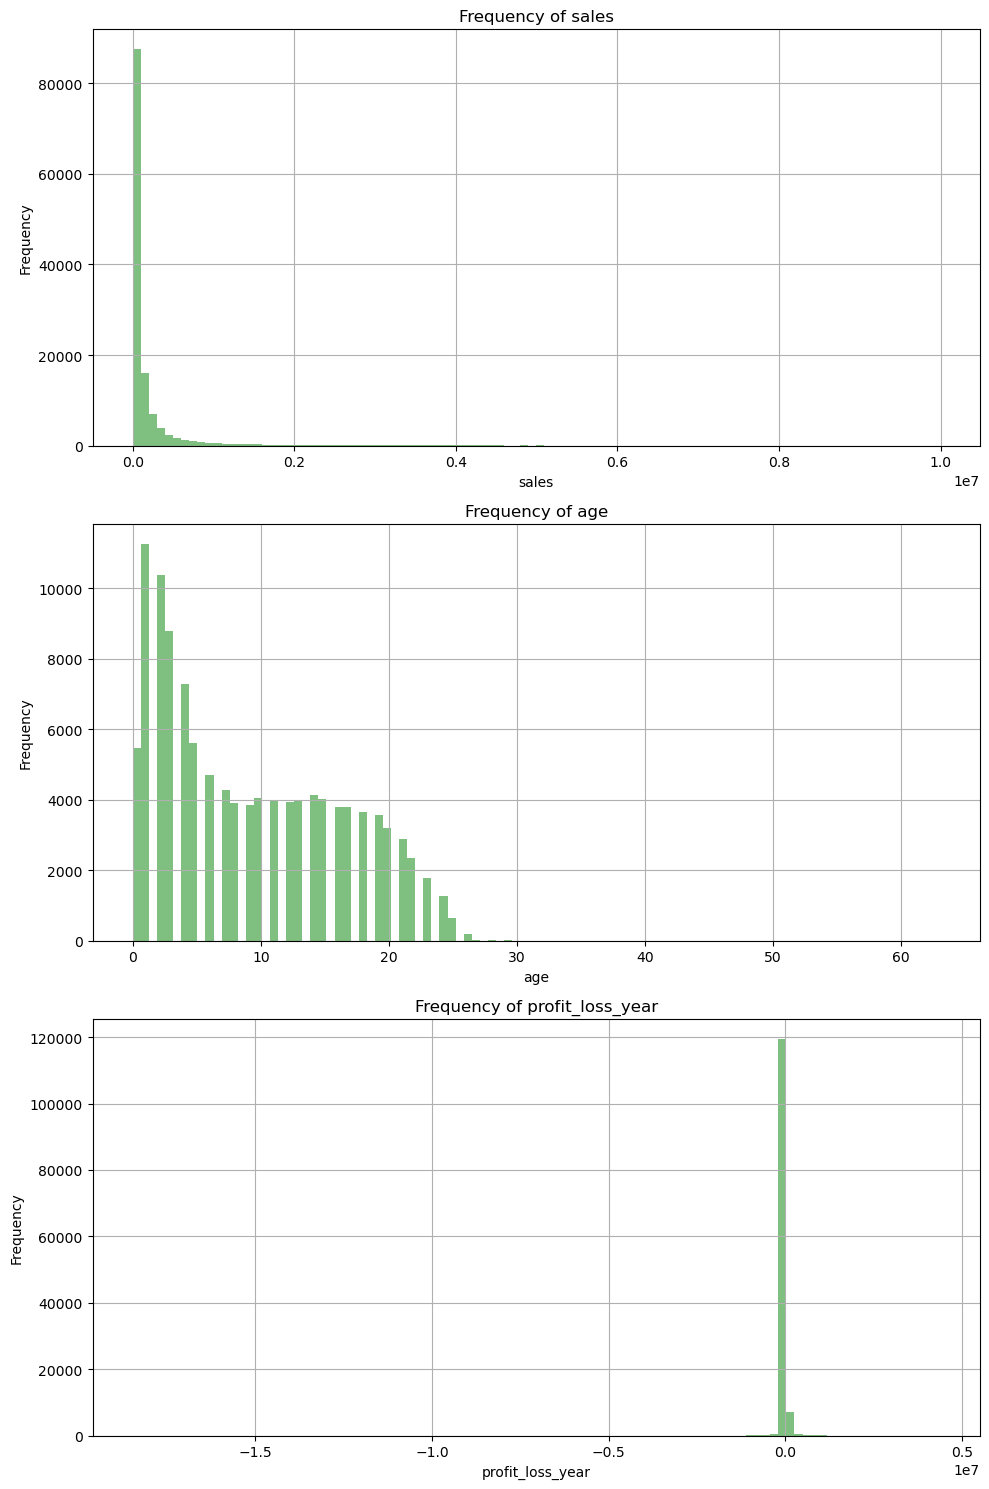

In [25]:
numeric_vars = ['sales', 'age', 'profit_loss_year']
fig, axs = plt.subplots(len(numeric_vars), figsize=(10, 5*len(numeric_vars)))

for i, var in enumerate(numeric_vars):
    axs[i].hist(data[var], bins=100, alpha=0.5, color='g')
    axs[i].set_title(f'Frequency of {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [26]:
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [27]:
data['ebtda'] = (data['inc_bef_tax_pl'] - data['extra_profit_loss_pl']) * data['sales'] + data['amort']

# Calculating NA ratios for ebtda, sales, and total_assets_bs by year
ebtda_sales_assets_na = data.groupby('year').agg(
    total=('year', 'size'),
    ebtda_na=('ebtda', lambda x: x.isnull().sum()),
    ebtda_na_ratio=('ebtda', lambda x: x.isnull().sum() / len(x)),
    sales_na=('sales', lambda x: x.isnull().sum()),
    sales_na_ratio=('sales', lambda x: x.isnull().sum() / len(x)),
    total_assets_na=('total_assets_bs', lambda x: x.isnull().sum()),
    assets_na_ratio=('total_assets_bs', lambda x: x.isnull().sum() / len(x))
)

In [28]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,ebtda
232060,2010,1.001034e+06,2010-01-01,2010-12-31,177.777771,2096.296387,19629.628906,0.000000,0.0,0.000000,...,42.000000,0,0,0,1,0.083333,0,default,21.272685,-7370.370178
232062,2010,1.002029e+06,2010-01-01,2010-12-31,22114.814453,230781.484375,202551.859375,0.000000,0.0,0.000000,...,35.000000,0,0,0,1,0.479167,0,no_default,0.028856,58244.443359
232063,2010,1.003200e+06,2010-01-01,2010-12-31,74.074074,922.222229,5388.888672,0.000000,0.0,0.000000,...,47.041769,0,0,1,1,0.666376,1,no_default,18.349431,359.259254
232064,2010,1.004012e+06,2010-01-01,2010-12-31,0.000000,2670.370361,1066.666626,0.000000,0.0,0.000000,...,47.041769,0,0,1,1,0.083333,0,default,35.739107,292.592590
232066,2010,1.007261e+06,2010-09-08,2010-12-31,0.000000,2459.259277,1348.148193,0.000000,0.0,0.000000,...,48.000000,0,0,0,1,0.666376,1,default,37.507800,-740.740723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510512,2015,4.637275e+11,2015-01-01,2015-12-31,529.629639,22688.888672,5388.888672,0.000000,0.0,0.000000,...,39.000000,0,0,0,1,0.187500,0,no_default,7.528713,-7188.888916
510513,2015,4.637410e+11,2015-01-01,2015-12-31,285.185181,4262.962891,8366.666992,0.000000,0.0,0.000000,...,41.000000,0,0,0,1,0.116667,0,no_default,14.870301,-16303.703491
510524,2015,4.639820e+11,2015-01-01,2015-12-31,14433.333008,72855.554688,97992.593750,0.000000,0.0,0.000000,...,58.000000,0,0,0,0,0.625000,0,no_default,0.573412,24096.295898
510526,2015,4.640212e+11,2015-01-01,2015-12-31,6633.333496,12970.370117,3185.185303,0.000000,0.0,0.000000,...,65.000000,0,0,0,0,0.180556,0,no_default,10.138598,885.185547


In [29]:
data['t2_ebtda'] = data.groupby('comp_id')['ebtda'].shift(-2)

# Filtering companies with positive assets only
data = data[data['total_assets_bs'] > 0]

# Calculating ebtda_to_assets ratio
data['ebtda_to_assets'] = (data['t2_ebtda'] - data['ebtda']) / data['total_assets_bs']
data = data.dropna(subset=['ebtda_to_assets'])

In [30]:
data['f_d1_sales_mil_log_low'] = np.where(data['d1_sales_mil_log'] < -1.5, 1, 0)
data['f_d1_sales_mil_log_high'] = np.where(data['d1_sales_mil_log'] > 1.5, 1, 0)
data['d1_sales_mil_log_mod'] = np.where(data['d1_sales_mil_log'] < -1.5, -1.5,
                                        np.where(data['d1_sales_mil_log'] > 1.5, 1.5, data['d1_sales_mil_log']))
data['d1_sales_mil_log_mod_sq'] = data['d1_sales_mil_log_mod'] ** 2

In [31]:
df_columns = pd.DataFrame(data.columns, columns=['Columns'])
df_columns

,Columns
0,year
1,comp_id
2,begin
3,end
4,amort
...,...
118,ebtda_to_assets
119,f_d1_sales_mil_log_low
120,f_d1_sales_mil_log_high
121,d1_sales_mil_log_mod


From here we build the new dataset for the actual analysis

In [32]:

#selected_columns = ['comp_id', 'year', 'status_alive', 'sales_mil_log', 'age', 'age2', 'ind', 'ind2_cat',
                   # 'd1_sales_mil_log_mod', 'd1_sales_mil_log_mod_sq', 'f_d1_sales_mil_log_high',
                    #'f_d1_sales_mil_log_low', 'foreign_management', 'female', 'urban_m', 'ebtda', "ebtda_to_assets",
                    # "female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age", "flag_miss_ceo_age", "ceo_count", 
                    # "labor_avg_mod", "flag_miss_labor_avg", "foreign_management"]

In [33]:
data['fast_growth'] = data.groupby(['ind2_cat', 'year'])['ebtda_to_assets'].transform(lambda x: x >= x.quantile(0.75))

In [34]:
threshold = 5
na_counts_per_row = data.isnull().sum(axis=1)

rows_with_many_na = data[na_counts_per_row >= threshold]
count_rows_with_many_na = len(rows_with_many_na)

print(f"Number of rows with at least {threshold} NaN values: {count_rows_with_many_na}")
na_counts_per_row = data.isnull().sum(axis=1)
data_cleaned = data[na_counts_per_row < threshold]
print(data_cleaned.head())

Number of rows with at least 5 NaN values: 0
        year    comp_id       begin         end         amort    curr_assets  \
232062  2010  1002029.0  2010-01-01  2010-12-31  22114.814453  230781.484375   
232063  2010  1003200.0  2010-01-01  2010-12-31     74.074074     922.222229   
232067  2010  1011889.0  2010-01-01  2010-12-31  27514.814453  105433.343750   
232068  2010  1014183.0  2010-01-01  2010-12-31  10281.481445  149503.703125   
232070  2010  1022796.0  2010-01-01  2010-12-31   1537.036987    8192.592773   

            curr_liab  extra_exp  extra_inc  extra_profit_loss  ...  \
232062  202551.859375        0.0        0.0                0.0  ...   
232063    5388.888672        0.0        0.0                0.0  ...   
232067    6611.111328        0.0        0.0                0.0  ...   
232068    3622.222168        0.0        0.0                0.0  ...   
232070    1577.777832        0.0        0.0                0.0  ...   

         default_f  sales_mil_log_sq         eb

In [35]:
variables_with_na = data.columns[data.isna().any()].tolist()
numeric_variables_with_na = [var for var in variables_with_na if np.issubdtype(data[var].dtype, np.number)]
categorical_variables_with_na = list(set(variables_with_na) - set(numeric_variables_with_na))
for variable in categorical_variables_with_na:
    data[variable] = data[variable].astype('object')
for variable in numeric_variables_with_na:
    mean_value = data[variable].mean()
    data[variable].fillna(mean_value, inplace=True)

for variable in categorical_variables_with_na:
    mode_value = data[variable].mode()[0]
    data[variable].fillna(mode_value, inplace=True)

print("Numeric columns with NaNs:", numeric_variables_with_na)
print("Categorical columns with NaNs:", categorical_variables_with_na)
numeric_variables_with_na = [var for var in variables_with_na if np.issubdtype(data[var].dtype, np.number)]
categorical_variables_with_na = list(set(variables_with_na) - set(numeric_variables_with_na))

for variable in numeric_variables_with_na:
    mean_value = data[variable].mean()
    data[variable].fillna(mean_value, inplace=True)
for variable in categorical_variables_with_na:
    mode_value = data[variable].mode()[0]
    data[variable].fillna(mode_value, inplace=True)

print("Numeric columns with NaNs:", numeric_variables_with_na)
print("Categorical columns with NaNs:", categorical_variables_with_na)

Numeric columns with NaNs: ['D', 'exit_year', 'birth_year']
Categorical columns with NaNs: ['exit_date']
Numeric columns with NaNs: ['D', 'exit_year', 'birth_year']
Categorical columns with NaNs: ['exit_date']


In [36]:
columns_to_drop = ['exit_date', 'founded_date', 'origin']
data = data.drop(columns=columns_to_drop)

In [37]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,default_f,sales_mil_log_sq,ebtda,t2_ebtda,ebtda_to_assets,f_d1_sales_mil_log_low,f_d1_sales_mil_log_high,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,fast_growth
232062,2010,1.002029e+06,2010-01-01,2010-12-31,22114.814453,230781.484375,202551.859375,0.0,0.000000,0.000000,...,no_default,0.028856,58244.443359,26748.148438,-0.113955,0,0,0.000000,0.000000,False
232063,2010,1.003200e+06,2010-01-01,2010-12-31,74.074074,922.222229,5388.888672,0.0,0.000000,0.000000,...,no_default,18.349431,359.259254,-2311.111183,-1.427723,0,0,0.000000,0.000000,False
232067,2010,1.011889e+06,2010-01-01,2010-12-31,27514.814453,105433.343750,6611.111328,0.0,0.000000,0.000000,...,no_default,1.154608,72477.779297,133377.777344,0.066279,0,0,0.000000,0.000000,False
232068,2010,1.014183e+06,2010-01-01,2010-12-31,10281.481445,149503.703125,3622.222168,0.0,0.000000,0.000000,...,no_default,4.979001,14403.703613,11114.814517,-0.011698,0,0,0.000000,0.000000,False
232070,2010,1.022796e+06,2010-01-01,2010-12-31,1537.036987,8192.592773,1577.777832,0.0,0.000000,0.000000,...,no_default,12.497002,-7992.592896,-574.074097,0.502257,0,0,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417670,2013,4.633865e+11,2013-01-01,2013-12-31,1722.222168,3325.926025,337.037048,0.0,0.000000,0.000000,...,no_default,15.463885,1899.999939,4018.518491,0.046763,0,0,-0.147677,0.021808,False
417682,2013,4.635828e+11,2013-01-01,2013-12-31,44.444443,1522.222168,166.666672,0.0,185.185181,185.185181,...,no_default,23.525539,1733.333359,-5944.444336,-3.300955,0,0,0.060980,0.003719,False
417688,2013,4.637275e+11,2013-01-01,2013-12-31,0.000000,9311.111328,211.111115,0.0,0.000000,0.000000,...,no_default,28.580871,-2007.407349,-7188.888916,-0.556484,0,0,0.000000,0.000000,False
417700,2013,4.639820e+11,2013-01-01,2013-12-31,12003.704102,109114.812500,150618.515625,0.0,0.000000,0.000000,...,no_default,0.987503,52311.110352,24096.295898,-0.128010,0,0,0.662642,0.439095,False


In [38]:
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])
data["age"].describe()

count    57085.000000
mean         9.282684
std          6.797152
min          0.000000
25%          3.000000
50%          9.000000
75%         15.000000
max         32.000000
Name: age, dtype: float64

In [39]:
data

,year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,default_f,sales_mil_log_sq,ebtda,t2_ebtda,ebtda_to_assets,f_d1_sales_mil_log_low,f_d1_sales_mil_log_high,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq,fast_growth
232062,2010,1.002029e+06,2010-01-01,2010-12-31,22114.814453,230781.484375,202551.859375,0.0,0.000000,0.000000,...,no_default,0.028856,58244.443359,26748.148438,-0.113955,0,0,0.000000,0.000000,False
232063,2010,1.003200e+06,2010-01-01,2010-12-31,74.074074,922.222229,5388.888672,0.0,0.000000,0.000000,...,no_default,18.349431,359.259254,-2311.111183,-1.427723,0,0,0.000000,0.000000,False
232067,2010,1.011889e+06,2010-01-01,2010-12-31,27514.814453,105433.343750,6611.111328,0.0,0.000000,0.000000,...,no_default,1.154608,72477.779297,133377.777344,0.066279,0,0,0.000000,0.000000,False
232068,2010,1.014183e+06,2010-01-01,2010-12-31,10281.481445,149503.703125,3622.222168,0.0,0.000000,0.000000,...,no_default,4.979001,14403.703613,11114.814517,-0.011698,0,0,0.000000,0.000000,False
232070,2010,1.022796e+06,2010-01-01,2010-12-31,1537.036987,8192.592773,1577.777832,0.0,0.000000,0.000000,...,no_default,12.497002,-7992.592896,-574.074097,0.502257,0,0,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417670,2013,4.633865e+11,2013-01-01,2013-12-31,1722.222168,3325.926025,337.037048,0.0,0.000000,0.000000,...,no_default,15.463885,1899.999939,4018.518491,0.046763,0,0,-0.147677,0.021808,False
417682,2013,4.635828e+11,2013-01-01,2013-12-31,44.444443,1522.222168,166.666672,0.0,185.185181,185.185181,...,no_default,23.525539,1733.333359,-5944.444336,-3.300955,0,0,0.060980,0.003719,False
417688,2013,4.637275e+11,2013-01-01,2013-12-31,0.000000,9311.111328,211.111115,0.0,0.000000,0.000000,...,no_default,28.580871,-2007.407349,-7188.888916,-0.556484,0,0,0.000000,0.000000,False
417700,2013,4.639820e+11,2013-01-01,2013-12-31,12003.704102,109114.812500,150618.515625,0.0,0.000000,0.000000,...,no_default,0.987503,52311.110352,24096.295898,-0.128010,0,0,0.662642,0.439095,False


In [40]:
data.to_csv('/Users/galamboslajos/Desktop/Assignment_3/cleandata.csv', index=False)
